### Mutual information score - Feature Selection

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
m = df.isna().sum()
m[m>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

Sepearte X and Y

In [5]:
X = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
Y = df[['Survived']]

In [6]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [7]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


Cat and Con seperation for X

In [8]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [9]:
cat

['Sex', 'Embarked']

In [10]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Create a pipeline for feature selection

1. Use Ordinal encoder for Cat features

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [12]:
num_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

In [13]:
cat_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('ordinal', OrdinalEncoder())])

In [14]:
pre1 = ColumnTransformer([('num', num_pipe1, con),
                          ('cat', cat_pipe1, cat)]).set_output(transform='pandas')


In [15]:
pre1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

In [16]:
X_pre = pre1.fit_transform(X)
X_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


Perform feature selection with mutual information scores

In [17]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_pre, Y)
mi

array([0.07462315, 0.04340693, 0.00589502, 0.0349224 , 0.1315342 ,
       0.14877159, 0.        ])

In [18]:
mi = pd.Series(mi)
mi.index = X_pre.columns
mi = mi.sort_values(ascending=False)
mi

cat__Sex         0.148772
num__Fare        0.131534
num__Pclass      0.074623
num__Age         0.043407
num__Parch       0.034922
num__SibSp       0.005895
cat__Embarked    0.000000
dtype: float64

<Axes: title={'center': 'Mutual Information Scores'}>

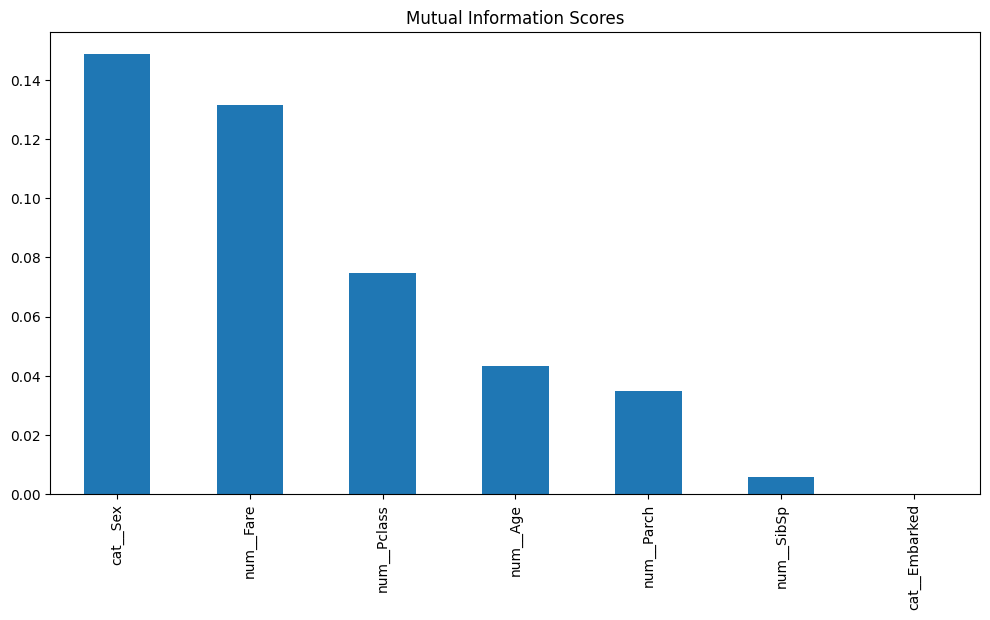

In [19]:
mi.plot(kind='bar', title='Mutual Information Scores', figsize=(12,6))

Select top 5 feature

In [20]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif, k=5)
sel.fit(X_pre, Y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__Age', 'num__Fare', 'cat__Sex',
       'cat__Embarked'], dtype=object)

Get the original column names

In [21]:
sel_cols[0].split('__')


['num', 'Pclass']

In [22]:
sel_cols[0].split('__')[1]

'Pclass'

In [23]:
imp_cols = []
for i in sel_cols:
    s = i.split('__')[1]
    imp_cols.append(s)

In [24]:
imp_cols

['Pclass', 'Age', 'Fare', 'Sex', 'Embarked']

In [25]:
X_imp = X[imp_cols]
X_imp

,Pclass,Age,Fare,Sex,Embarked
0,3,22.0,7.2500,male,S
1,1,38.0,71.2833,female,C
2,3,26.0,7.9250,female,S
3,1,35.0,53.1000,female,S
4,3,35.0,8.0500,male,S
...,...,...,...,...,...
886,2,27.0,13.0000,male,S
887,1,19.0,30.0000,female,S
888,3,NaN,23.4500,female,S
889,1,26.0,30.0000,male,C


Seperate cat and con features for selected columns

In [26]:
cat_sel = list(X_imp.columns[X_imp.dtypes=='object'])
con_sel = list(X_imp.columns[X_imp.dtypes!='object'])

In [27]:
cat_sel

['Sex', 'Embarked']

In [28]:
con_sel

['Pclass', 'Age', 'Fare']

Create a final preprocessing pipeline

cat-OneHotEncoder

In [29]:
from sklearn.preprocessing import OneHotEncoder


In [30]:
num_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

In [31]:
cat_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('OHE', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [32]:
pre2 = ColumnTransformer([('num', num_pipe2, con_sel),
                          ('cat', cat_pipe2, cat_sel)]).set_output(transform='pandas')

In [33]:
X_sel_pre = pre2.fit_transform(X_imp)
X_sel_pre.head()

,num__Pclass,num__Age,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.565736,-0.502445,0.0,1.0,0.0,0.0,1.0
1,-1.566107,0.663861,0.786845,1.0,0.0,1.0,0.0,0.0
2,0.827377,-0.258337,-0.488854,1.0,0.0,0.0,0.0,1.0
3,-1.566107,0.433312,0.420730,1.0,0.0,0.0,0.0,1.0
4,0.827377,0.433312,-0.486337,0.0,1.0,0.0,0.0,1.0


Apply train test split for X_sel_pre

In [34]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_sel_pre, Y, test_size=0.2, random_state=21)



In [35]:
xtrain.shape

(712, 8)

In [36]:
xtest.shape

(179, 8)

### Create a Logistic regression algorithm

In [37]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(xtrain, ytrain)

LogisticRegression()

In [38]:
model.score(xtrain, ytrain)

0.7921348314606742

In [39]:
model.score(xtest, ytest)

0.7821229050279329

Predict results for train and test

In [40]:
ypred_tr = model.predict(xtrain)
ypred_ts = model.predict(xtest)

In [41]:
ypred_tr[0:5]

array([1, 0, 1, 1, 0], dtype=int64)

In [42]:
ytrain.head()

,Survived
793,0
23,1
97,1
9,1
157,0


In [43]:
ypred_ts[0:5]

array([1, 0, 0, 0, 0], dtype=int64)

In [44]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


Create confusion matrix

In [45]:
c = model.classes_
c

array([0, 1], dtype=int64)

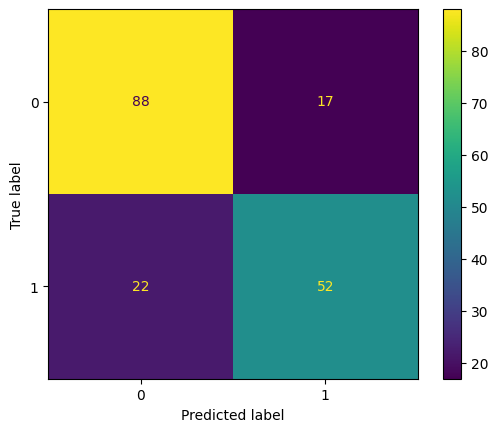

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(ytest, ypred_ts)
cfd = ConfusionMatrixDisplay(cf, display_labels=c)
cfd.plot()

Classification report

In [47]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       105
           1       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



Predict ressults for out of sample data

In [48]:
xnew = pd.read_csv('test_titanic copy.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [49]:
pre2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OHE',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

Apply pre.transform on out of sample data

In [50]:
xnew_pre = pre2.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Age,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,0.394887,-0.490783,0.0,1.0,0.0,1.0,0.0
1,0.827377,1.355510,-0.507479,1.0,0.0,0.0,0.0,1.0
2,-0.369365,2.508257,-0.453367,0.0,1.0,0.0,1.0,0.0
3,0.827377,-0.181487,-0.474005,0.0,1.0,0.0,0.0,1.0
4,0.827377,-0.565736,-0.401017,1.0,0.0,0.0,0.0,1.0


Predict the results and probability

In [51]:
preds = model.predict(xnew_pre)
preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [52]:
model.classes_

array([0, 1], dtype=int64)

In [53]:
prob = model.predict_proba(xnew_pre)[:, 1]
prob[0:5]

array([0.10257004, 0.38121409, 0.12806141, 0.08369026, 0.5751483 ])

Save above in dataframe

In [54]:
df_final = xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [55]:
df_final['Survived_pred']=preds
df_final['Survuved_prob']=prob

In [56]:
df_final

,PassengerId,Survived_pred,Survuved_prob
0,892,0,0.102570
1,893,0,0.381214
2,894,0,0.128061
3,895,0,0.083690
4,896,1,0.575148
...,...,...,...
413,1305,0,0.081340
414,1306,1,0.921512
415,1307,0,0.059720
416,1308,0,0.081340


Save above results to CSV

In [57]:
df_final.to_csv('results.csv', index=False)

Plot how many people survived

In [58]:
df_final['Survived_pred'].value_counts()

Survived_pred
0    258
1    160
Name: count, dtype: int64

<Axes: xlabel='Survived_pred'>

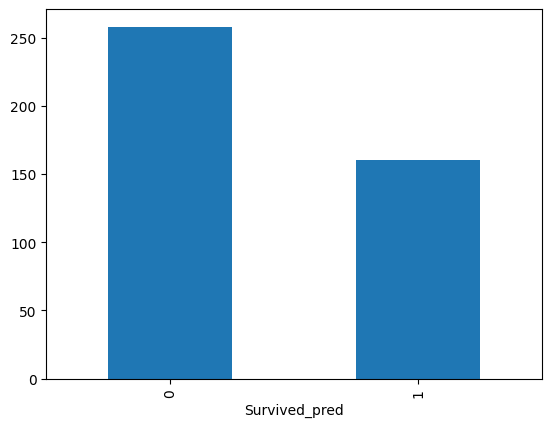

In [59]:
df_final['Survived_pred'].value_counts().plot(kind='bar')